<a href="https://colab.research.google.com/github/AlisonZa/CNNpneumonia/blob/main/XrayPneumoniaClassificationCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tags:

[ImageData][TensorFlowDataset][HealthCare][XrayAnalysis]

Future Improvements:

*   Implement Data Augumentation to solve the imbalance class problems



# 0. Setup and function definition

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os

from PIL import Image

from sklearn.decomposition import PCA

from math import ceil

from google.colab import drive

from tensorflow import keras

from keras import layers
from keras.utils import to_categorical,load_img
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import Sequential,load_model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.metrics import categorical_crossentropy, binary_crossentropy, Recall
from keras.optimizers import SGD, Adam
from keras.callbacks import TensorBoard, ModelCheckpoint

# Assuring Reproducibility
SEED = 42
np.seed = SEED
np.random.seed(SEED)
tf.random.set_seed(SEED)
keras.utils.set_random_seed(SEED)


In [4]:
# Functions definition

# Viewing a Sampling of Images
def plot_sample_images(dataset, num_images=10, num_rows=2, num_cols=5):
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))
    for images, _ in dataset.take(1):
        for i in range(num_rows):
            for j in range(num_cols):
                image = images[i * num_cols + j].numpy().astype("uint8")

                # Plot the image
                axes[i, j].imshow(image, cmap='gray')
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Convert images to numpy arrays
def images_in_directory_to_np_arrays(directory_path, size=(64, 64), color_mode='L'):
    full_mat = None

    # Iterate through each file in the directory
    for filename in os.listdir(directory_path):
        filepath = os.path.join(directory_path, filename)

        # Open and resize the image using PIL
        current_image = Image.open(filepath).resize(size)

        # Convert image to a matrix
        img_np = np.array(current_image.convert(color_mode))
        # Flatten the image into a vector / 1D array
        img_np = img_np.ravel()

        try:
            # Concatenate different images
            full_mat = np.concatenate((full_mat, [img_np]))
        except (UnboundLocalError, ValueError):
            # If not assigned yet or if concatenation fails, assign one
            full_mat = np.array([img_np])

    return full_mat

# Create average image
def find_mean_img(full_mat, title, size = (64, 64)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img

# Eigenimages
def eigenimages(full_mat, title, n_comp = 0.7, size = (64, 64)):
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca

# Plot eigenimages in a grid
def plot_pca(pca, size = (64, 64)):

    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size),
                  cmap='Greys_r')
    plt.axis('off')
    plt.show()


# 1. Frame the problem and look at the big picture.

## 1. Define the objective in business terms.

We are going to create a deep learning model with Convolutional Layers that will perform pneumonia classification by analyzing X-ray images

The classification problem is Binary.

## 2. How will your solution be used?

The model can be used to automate the XRay Analysis, being particulary important in low income regions, and places that do not have well developed medical structures.


Perhaps, this model could improve the efficience of medical work, reduce the error margin, and help to optimize the cost structure of hospitals and clinics.

## 3. What are the current solutions/workarounds (if any)?

There are some solutions that perform similar tasks, the most simillar one found is the model by Shagun Sharma and, which  provides an accuracy value of 92.15% and recall as 93,08%


## 4. How should you frame this problem (supervised/unsupervised, etc.)?

The problem is:

🔎 Supervised (the data is already labeled)

0️⃣/1️⃣   Binary (the goal is to predict whether the XRay indicates pneumonia or not)

👨‍⚕️   Risk-sensitive



## 5. How should performance be measured?

The principal metrics are:


1.   Recall (since we are dealing with a risk-sensitive situation)
2.   Accuracy



## 6. Is the performance measure aligned with the business objective?

✅

## 7. What would be the minimum performance needed to reach the business objective?

The current Neural Networks "BenchmarkModel" provides an accuracy value of 92.15% and recall as 93,08%.

🚀 Our mission is to improve those metrics.




## 8. What are comparable problems? Can you reuse experience or tools?

Yes, there are many others convolutional neural networks avaiable on the internet. However, the neural network referenced in the previous cell, already has a great performance and  a lot of sinergy with the current problem.



## 9. Is human expertise available?

No, we do not have acess to human expertise at the moment.

## 10. How would you solve the problem manually?

With Medical and Radiologist expertise

# 2. Get the data.

---



## 1. List the data you need and how much you need.

We are going to need labeled X-ray images files, with the binary classification of pneumonia occurrence.

## 2. Find and document where you can get that data.



 The data can be obtained from the Labeled Optical Coherence Tomography (OCT) and Chest X-Ray Images for Classification Dataset.


## 3. Check how much space it will take.

Our entire Dataset is going to use 1,16 GB.

We are going to store the data in Google Drive

## 4. Check legal obligations, and get authorization if necessary.

According to the dataset site, it has the CC BY 4.0 license description.

That means we can use the data as long as we give the appropriate credit, provide the link, and document the changes that we are going to make.

## 5. Get access authorizations.

✅

## 6. Create a workspace (with enough storage space).




In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 7. Get the data.

To split the data into train, test and validation, we ran the ImageFolderSplitting.ipynb using the ratios of 70%, 20%,10%

In [6]:
adress_train = '/content/drive/MyDrive/data_pneumonia_detection/chest_xray/train'
adress_test ='/content/drive/MyDrive/data_pneumonia_detection/chest_xray/test'
adress_val ='/content/drive/MyDrive/data_pneumonia_detection/chest_xray/val'

## 8. Convert the data to a format you can easily manipulate (without changing the data itself).

In [7]:
train_data = tf.keras.utils.image_dataset_from_directory(adress_train)
test_data = tf.keras.utils.image_dataset_from_directory(adress_test)
val_data = tf.keras.utils.image_dataset_from_directory(adress_val)

# Dataset from directory atributes 0 to the first class in alfabetical order, so Pneumonia = 1, Normal = 0

Found 4099 files belonging to 2 classes.
Found 587 files belonging to 2 classes.
Found 1170 files belonging to 2 classes.


## 9. Ensure sensitive information is deleted or protected (e.g., anonymized).

✅ All the information is already anonymized

## 10. Check the size and type of data (time series, sample, geographical, etc.).


We are dealing with X-ray **samples**


## 11. Sample a test set, put it aside, and never look at it (no data snooping!)

✅ Already done in cell 2.8

# 3. Explore the data to gain insights.


## 1. Visualize the data.


In [8]:
number_classes = {
'Class_0': len(os.listdir('/content/drive/MyDrive/data_pneumonia_detection/chest_xray/train/NORMAL')),
'Class_1': len(os.listdir('/content/drive/MyDrive/data_pneumonia_detection/chest_xray/train/PNEUMONIA')),
}

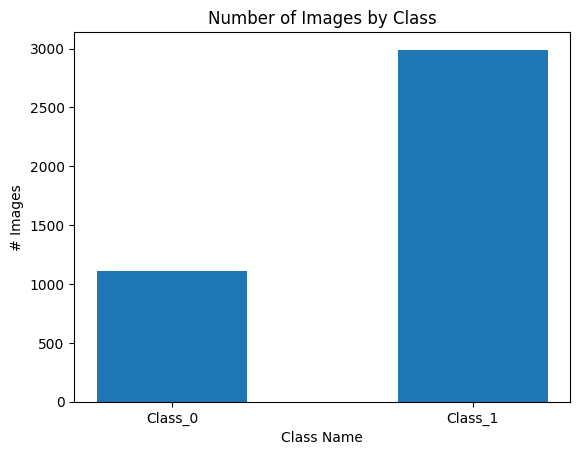

In [9]:
plt.bar(number_classes.keys(), number_classes.values(), width = .5);
plt.title("Number of Images by Class");
plt.xlabel('Class Name');
plt.ylabel('# Images');

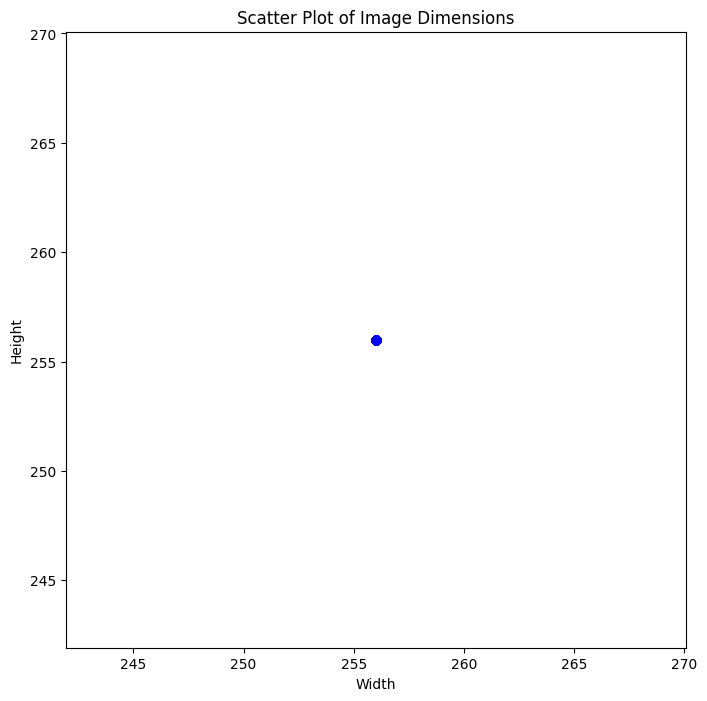

In [10]:
image_dimensions = []
for images, _ in train_data:
    for image in images:
        height, width, _ = image.shape
        image_dimensions.append((height, width))

# # Create a scatter plot
heights, widths = zip(*image_dimensions)

plt.figure(figsize=(8, 8))
plt.scatter(widths, heights, alpha=0.5, color='blue')
plt.title('Scatter Plot of Image Dimensions')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()

The tf.dataset (data loading function) has already normalized the images dimensions

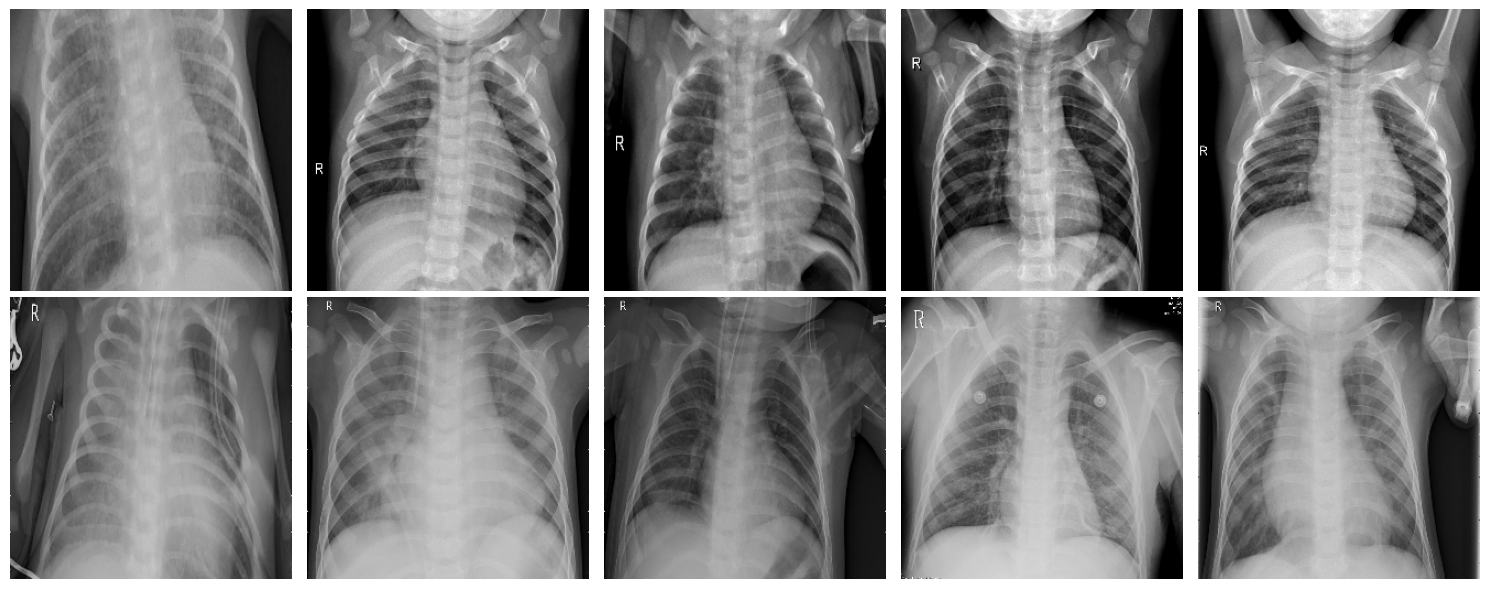

In [11]:
# Plotting sample images
plot_sample_images(train_data, num_images=10, num_rows=2, num_cols=5)

In [12]:
# Converting images to Matrix
normal_imgs = [fn for fn in os.listdir(f'{adress_train}/NORMAL')]
pneumo_imgs = [fn for fn in os.listdir(f'{adress_train}/PNEUMONIA')]

# Converting images to NumPy arrays
normal_images = images_in_directory_to_np_arrays(f'{adress_train}/NORMAL')
pneumonia_images = images_in_directory_to_np_arrays(f'{adress_train}/PNEUMONIA')

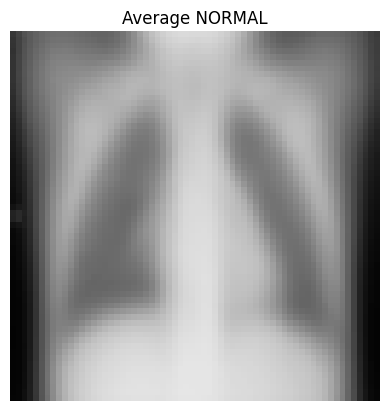

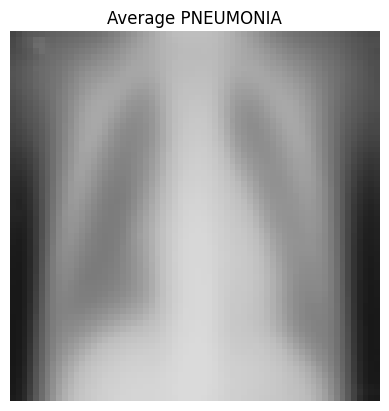

In [13]:
# Ploting the avarage image for each class
norm_mean = find_mean_img(normal_images, 'NORMAL')
pneu_mean = find_mean_img(pneumonia_images, 'PNEUMONIA')

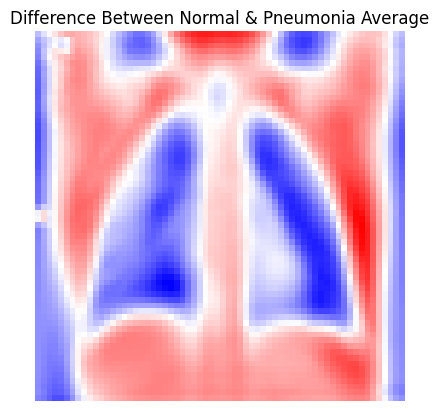

In [14]:
# Contrast Plot
contrast_mean = norm_mean - pneu_mean
plt.imshow(contrast_mean, cmap='bwr')
plt.title(f'Difference Between Normal & Pneumonia Average')
plt.axis('off')
plt.show()


**Blue** Represents positive differences. In the context of the code, it indicates areas where the pixel values in the "Normal" images are higher than those in the "Pneumonia" images.

**White**: Represents zero differences. It indicates areas
where the pixel values in both sets of images are the same.

**Red**: Represents negative differences. In the context of the code, :it indicates areas where the pixel values in the "Normal" images are lower than those in the "Pneumonia" images.


As we can see the lungs specially the left one are darker in the Xray images,
wich says to us that the non-pneumoniac lungs have a tinier lung obstruction.


Lastly, we can utilize a dimension reduction technique, such as Principal Component Analysis (PCA), to visualize the components that best describe each class. The eigenimages, essentially the eigenvectors (components) of the PCA of our image matrix, can be reshaped into a matrix and plotted. This approach is also known as eigenfaces, originally used in facial recognition research. We will visualize the principal components that account for 70% of the variability for each class.

Number of PC:  17


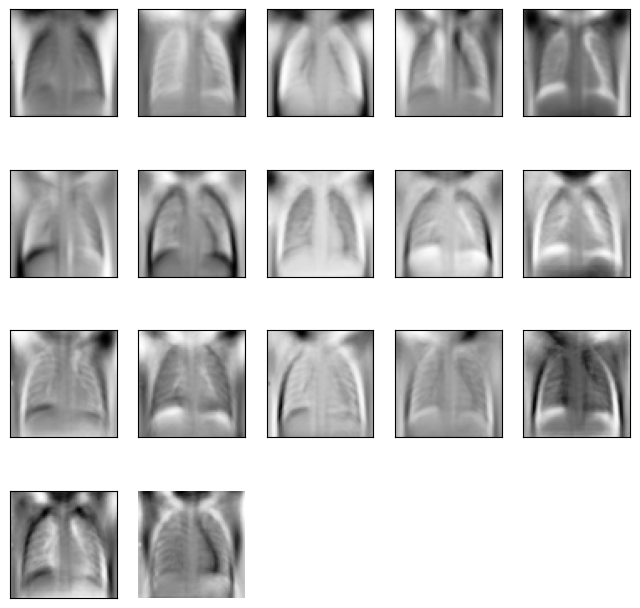

Number of PC:  11


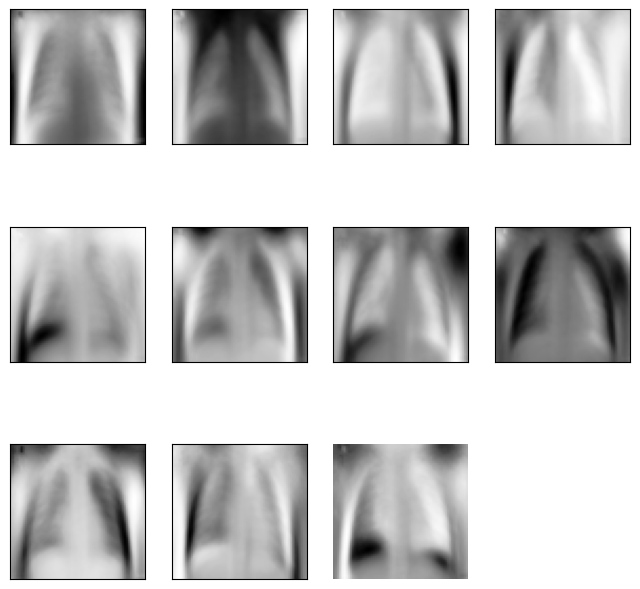

In [15]:
plot_pca(eigenimages(normal_images, 'NORMAL'))
plot_pca(eigenimages(pneumonia_images, 'PNEUMONIA'))

Healthy X-rays have higher definition in the rib cages

## 2. Identify the promising transformations you may want to apply

1.   Data normalization will be needed, since the ML algorithms works better with values between 0 and 1
2.   A future improvement has been added, to solve the class imbalance problem


## 3. Document what you have learned.

*   Chest X-rays with pneumonia tend to exhibit larger obstructions.
*   Healthy X-Ray have more clear regions in the lungs, specially at the left outside
*   The ImageDimensions are already treated (256x256) in the dataset creation




# 4. Prepare the data to better expose the underlying data patterns to machine learning algorithms.

---



## 1. Perform feature scaling:


In [16]:
train_data = train_data.map(lambda x,y: (x/255, y))
test_data = test_data.map(lambda x,y: (x/255, y))
val_data = val_data.map(lambda x,y: (x/255, y))

In [17]:
# Checking if feature scaling was properly performed

# Convert the dataset to NumPy arrays using tfds.as_numpy
numpy_dataset = tfds.as_numpy(train_data)

min_values = float('inf')
max_values = float('-inf')

# # Iterate through the dataset to find the minimum values
for example in numpy_dataset:
    image = example[0]
    min_image_value = np.min(image)
    max_image_value = np.max(image)
    min_values = min(min_values, min_image_value)
    max_values = max(max_values, max_image_value)

In [18]:
print("Minimum pixel value in the dataset:", min_values)
print("Maximum pixel value in the dataset:", max_values)

Minimum pixel value in the dataset: 0.0
Maximum pixel value in the dataset: 1.0


✅ The data normalization was sucesfully performed

# 5. Explore models

## 1. Test Models


### VGG

The VGG16, which stands for "Visual Geometry Group 16," is a convolutional neural network (CNN) architecture designed for computer vision tasks, particularly object recognition in images. It was developed by the Visual Geometry Group at the Department of Engineering Science, University of Oxford.

**Key Features of the VGG16 Architecture:**

**Significant Depth**: VGG16 is known for its significant depth, featuring 16 layers of convolution and pooling. This depth helps in extracting complex and hierarchical features from images.

**Simple and Uniform Architecture**: A distinctive feature of VGG16 is its uniform architecture, where consecutive blocks consist of convolutional layers followed by pooling layers, making the architecture easy to understand and implement.

**Small Convolutional Filters**: VGG16 uses relatively small convolutional filters (3x3) in all convolutional layers. The use of these small filters allows for efficient representation of complex patterns.

**Fully Connected Layers and Final Classification**: After convolutional and pooling layers, VGG16 includes fully connected layers culminating in an output layer for final classification.

**Training on Large Datasets**: VGG16 is often trained on large datasets, such as the ImageNet dataset, to learn useful representations that can be transferred to other computer vision tasks.

The VGG16 has become a reference architecture in the field of computer vision and is frequently used as a starting point for image recognition problems and transfer learning. Its significant contributions have helped drive the development of more advanced convolutional neural networks.

In [19]:
def VGG16_binary():
    # Initialize the model
    model = Sequential()

    # layer 1-2: 2 convolutional layers + 1 max-pooling layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(256, 256, 3)))
    model.add(BatchNormalization())# add

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())# add

    model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    # number of filters and convolutions in each layer:
    filters_convs = [(128, 2), (256, 3), (512, 3), (512, 3)]

    for n_filters, n_convs in filters_convs:
        for _ in np.arange(n_convs):
            model.add(Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', activation='relu'))
        # max-pooling layer
        model.add(MaxPooling2D(pool_size=(2, 2), strides=2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    # Adjust the output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # compile the model with a loss function, a metric, and an optimization method
    opt = SGD(learning_rate=0.001)  # stochastic gradient descent method with learning rate lr = 0.001
    model.compile(loss=binary_crossentropy, # Changed for binary classification
                  optimizer=opt,
                  metrics=['accuracy','Recall']) # Changed for risk-sensitive task.

    return model

In [20]:
modelvgg16 = VGG16_binary()

In [21]:
modelvgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 256, 256, 64)      256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 batch_normalization_1 (Bat  (None, 256, 256, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                        

In [22]:
# Callbacks setup
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

modelcheckpoint = ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)

In [23]:
# Model training
modelvgg16_hist = modelvgg16.fit(train_data, epochs=40, validation_data=val_data, callbacks=[tensorboard_callback, early_stopping, modelcheckpoint])

Epoch 1/40
129/129 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.6904 - recall: 0.9101

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


129/129 [==============================] - 554s 4s/step - loss: 0.6721 - accuracy: 0.6904 - recall: 0.9101 - val_loss: 0.6750 - val_accuracy: 0.7299 - val_recall: 1.0000
Epoch 2/40
129/129 [==============================] - 96s 725ms/step - loss: 0.6271 - accuracy: 0.7297 - recall: 1.0000 - val_loss: 0.6497 - val_accuracy: 0.7299 - val_recall: 1.0000
Epoch 3/40
129/129 [==============================] - 87s 659ms/step - loss: 0.5919 - accuracy: 0.7297 - recall: 1.0000 - val_loss: 0.6193 - val_accuracy: 0.7299 - val_recall: 1.0000
Epoch 4/40
129/129 [==============================] - 89s 667ms/step - loss: 0.5566 - accuracy: 0.7365 - recall: 0.9987 - val_loss: 0.5663 - val_accuracy: 0.7299 - val_recall: 1.0000
Epoch 5/40
129/129 [==============================] - 89s 668ms/step - loss: 0.4472 - accuracy: 0.8043 - recall: 0.9555 - val_loss: 0.4009 - val_accuracy: 0.7983 - val_recall: 0.9930
Epoch 6/40
129/129 [==============================] - 99s 747ms/step - loss: 0.3398 - accuracy: 0.

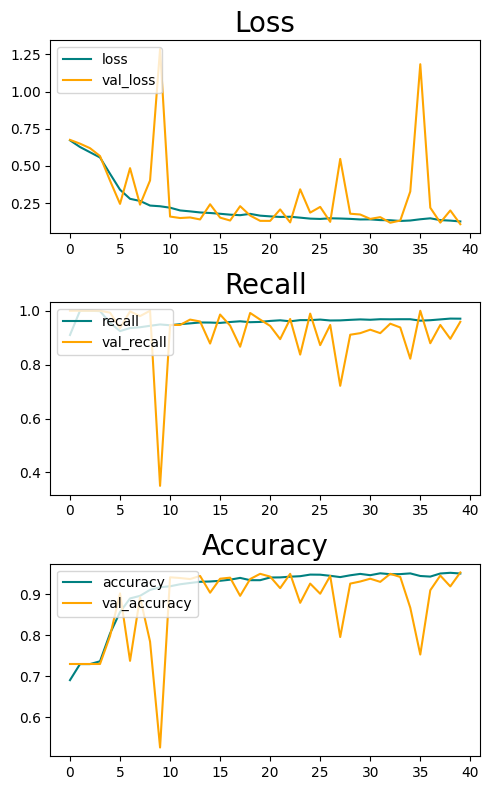

In [24]:
# Plotting the model performance throug epochs
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 8))

# Plotting loss and val_loss
axes[0].plot(modelvgg16_hist.history['loss'], color='teal', label='loss')
axes[0].plot(modelvgg16_hist.history['val_loss'], color='orange', label='val_loss')
axes[0].set_title('Loss', fontsize=20)
axes[0].legend(loc="upper left")

# Plotting recall and val_recall
axes[1].plot(modelvgg16_hist.history['recall'], color='teal', label='recall')
axes[1].plot(modelvgg16_hist.history['val_recall'], color='orange', label='val_recall')
axes[1].set_title('Recall', fontsize=20)
axes[1].legend(loc="upper left")

# Plotting accuracy and val_accuracy
axes[2].plot(modelvgg16_hist.history['accuracy'], color='teal', label='accuracy')
axes[2].plot(modelvgg16_hist.history['val_accuracy'], color='orange', label='val_accuracy')
axes[2].set_title('Accuracy', fontsize=20)
axes[2].legend(loc="upper left")

# Adjust layout
plt.tight_layout()
plt.show()

In [25]:
# Saving model
modelvgg16.save('modelvgg16.h5')

In [26]:
# Loading and testing model
modelvgg16 = load_model('modelvgg16.h5')
test_loss, test_accuracy, test_recall = modelvgg16.evaluate(test_data)

19/19 [==============================] - 213s 6s/step - loss: 0.1567 - accuracy: 0.9489 - recall: 0.9626


# Results:


We have reduced the error margin of Accuracy by 32,7389%

---

We have reduced the error margin of Accuracy by 52,7457%



# Acknowledgements

**Dataset:**

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2

License: CC BY 4.0

Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


---


**VGG16 Network**

Author: Khuyen Le

Title: An overview of VGG16 and NiN models

URL: https://medium.com/mlearning-ai/an-overview-of-vgg16-and-nin-models-96e4bf398484

---


**Exploratory Data Analysis**

Author: Eunjoo Byeon

Title: Exploratory Data Analysis Ideas for Image Classification

URL: https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

---
**General Machine Learning Workflow**

Author: Aurélien Géron

Title: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, third edition

Publisher: O’Reilly Media, 2023

---
**Benchmark Model**

Shagun Sharma, Kalpna Guleria,

A Deep Learning based model for the Detection of Pneumonia from Chest X-Ray Images using VGG-16 and Neural Networks,
Procedia Computer Science,

Volume 218,
2023,

Pages 357-366,

ISSN 1877-0509,

https://doi.org/10.1016/j.procs.2023.01.018.
(https://www.sciencedirect.com/science/article/pii/S1877050923000182)

